# Análise Exploratória de Dados (EDA)

**Projeto:** "Modelagem Preditiva de Risco de Crédito sob *Stress* Macroeconômico: uma abordade comparativa en *Ensemble Trees* e Regressão Regularizada"<br>
**Autor:** Pedro Rogério Pereira Júnior (Pereira Júnior, P. R.)<br>
**Data:** Dezembro/2025<br>

## 1. Objetivos da Análise
O objetivo deste notebook é investigar as relações históricas entre as taxas de inadimplência (PF e PJ) e os indicadores macroeconômicos e climáticos coletados. Buscamos responder:
1.  **Tendência:** Como a inadimplência evoluiu nos últimos 10 anos?
2.  **Sazonalidade e Eventos:** Como a pandemia e trocas de governo impactaram os índices?
3.  **Correlação:** Quais variáveis econômicas (Desemprego, Selic, IPCA) têm maior relação linear com a inadimplência?

In [3]:
# --- 1. Configurações e Bibliotecas ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from pathlib import Path

# Configurações visuais
sns.set_theme(style="whitegrid", context="talk") 
plt.rcParams["figure.figsize"] = (16, 7)
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 16

# Caminhos
BASE_PATH = Path("../data/raw/")

# --- 2. Carga e Fusão dos Dados ---
print("Carregando datasets...")

arquivos = {
    "inad": "df_inadimplencia.csv",
    "econ": "df_economico.csv",
    "ibge": "df_ibge.csv",
    "clima": "df_inmet.csv",
    "eventos": "df_eventos_politicos.csv"
}

dfs = []
for nome, arquivo in arquivos.items():
    caminho = BASE_PATH / arquivo
    
    if caminho.exists():
        df_temp = pd.read_csv(caminho)
        
        # 1. Converter Data para Datetime
        if "data" in df_temp.columns:
            df_temp["data"] = pd.to_datetime(df_temp["data"])
        
        # 2. CORREÇÃO: Remover a coluna 'data_str' se ela existir
        # Isso evita o erro de colunas duplicadas no merge
        if "data_str" in df_temp.columns:
            df_temp = df_temp.drop(columns=["data_str"])

        dfs.append(df_temp)
        print(f"Carregado: {nome} | Linhas: {len(df_temp)}")
    else:
        print(f"ERRO: Arquivo não encontrado: {arquivo}")

# --- 3. Merge ---
if dfs:
    # O reduce vai juntar um por um usando a coluna 'data'
    df_mestre = reduce(lambda left, right: pd.merge(left, right, on="data", how="outer"), dfs)

    # Ordenar e Limpar
    df_mestre = df_mestre.sort_values("data").reset_index(drop=True)
    df_mestre.set_index("data", inplace=True)

    # Filtrar a partir de 2015
    df_mestre = df_mestre[df_mestre.index >= "2015-01-01"]

    print(f"\nDataset consolidado com sucesso! Shape: {df_mestre.shape}")
    display(df_mestre.head(3))
else:
    print("Nenhum dado foi carregado.")

Carregando datasets...
Carregado: inad | Linhas: 120
Carregado: econ | Linhas: 240
Carregado: ibge | Linhas: 163
Carregado: clima | Linhas: 144
Carregado: eventos | Linhas: 120

Dataset consolidado com sucesso! Shape: (252, 32)


,inad_pj_tot,inad_pf_tot,inad_rd_pf_cr_rur_tot,inad_rd_pj_cr_rur_tot,ipca,spread_pf,spread_pj,spread_tot,icms_petroleo,soja_triturada_expt,...,p14m_fora_forca_trabalho_mil,tx_foca_trabalho_p14m_pct,tx_desocupacao_p14m_pct,insolacao_total_h,precipitacao_total_mm,temp_max_media_c,umidade_media_pct,flag_pandemia,flag_greve_caminhoneiros,presidente
data,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1.98,3.75,1.36,0.66,2.50,22.39,8.70,15.68,5556575.0,35102725.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Dilma
2015-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59812.0,62.4,8.0,230.26,118.75,32.58,70.55,NaN,NaN,NaN
2015-02-01,1.99,3.81,1.53,0.71,2.37,23.23,9.05,16.28,5494786.0,346160419.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Dilma


## 2. Verificação de Qualidade dos Dados
Análise rápida de valores nulos (missings) para garantir que não analisaremos períodos vazios.

In [4]:
# Verificação de nulos (Top 10 colunas com dados faltantes)
missing = df_mestre.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]

if not missing.empty:
    print("Variáveis com valores ausentes:")
    print(missing.head(10))
else:
    print("Dataset completo! Sem valores nulos.")

Variáveis com valores ausentes:
icms_petroleo                         200
soja_oleo_expt                        196
soja_triturada_expt                   196
soja_residuo_expt                     196
milho_grao_expt                       196
rendimento_medio_mensal_reais         143
tx_informalidade_p14m_ocupadas_pct    134
inad_pj_tot                           132
spread_tot                            132
spread_pj                             132
dtype: int64


## 3. Evolução Temporal da Inadimplência
Abaixo, visualizamos as curvas de inadimplência para Pessoas Físicas (PF) e Jurídicas (PJ).
* **Destaque:** O período sombreado representa a fase crítica da **Pandemia de COVID-19**, onde observamos comportamentos anômalos (possível efeito de moratórias bancárias ou injeção de liquidez).

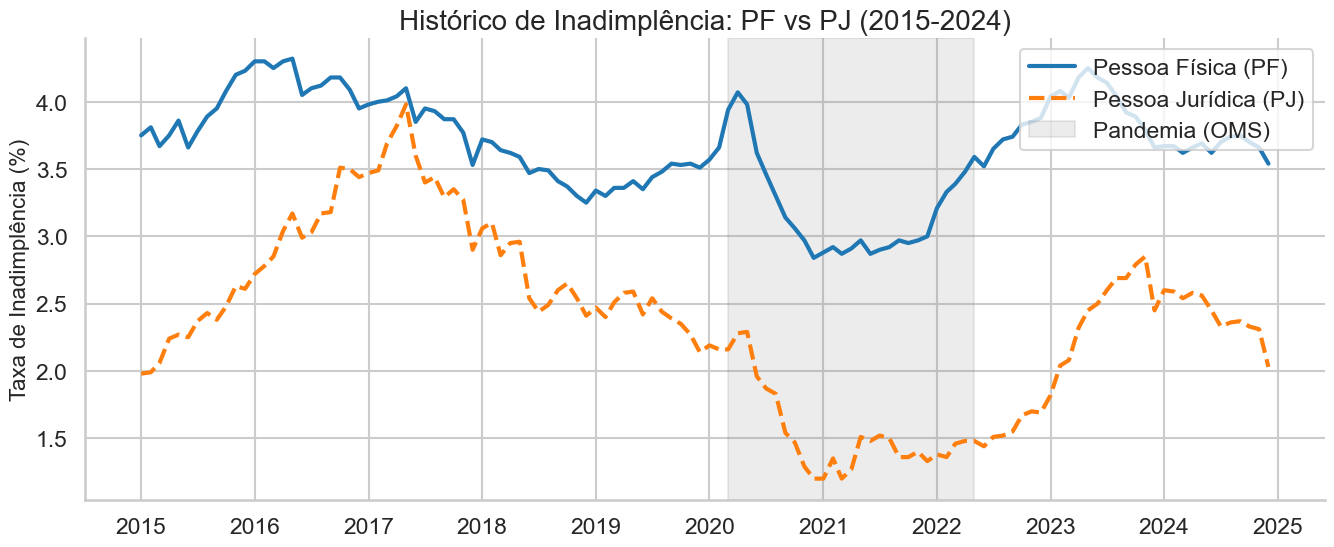

In [5]:
# Plot: Inadimplência Geral
plt.figure(figsize=(16, 6))

sns.lineplot(data=df_mestre, x=df_mestre.index, y="inad_pf_tot", label="Pessoa Física (PF)", linewidth=3, color="#1f77b4")
sns.lineplot(data=df_mestre, x=df_mestre.index, y="inad_pj_tot", label="Pessoa Jurídica (PJ)", linewidth=3, linestyle="--", color="#ff7f0e")

# Destaques de Eventos
plt.axvspan('2020-03-01', '2022-05-01', color='gray', alpha=0.15, label='Pandemia (OMS)')

# Estética
plt.title("Histórico de Inadimplência: PF vs PJ (2015-2024)")
plt.ylabel("Taxa de Inadimplência (%)")
plt.xlabel("")
plt.legend(loc="upper right")
sns.despine() # Remove bordas desnecessárias (superior e direita)

plt.show()

### 3.1. Foco no Crédito Rural
O crédito rural possui dinâmica própria, muitas vezes descolada da economia urbana devido aos ciclos de safra e preços de commodities (Soja/Milho).

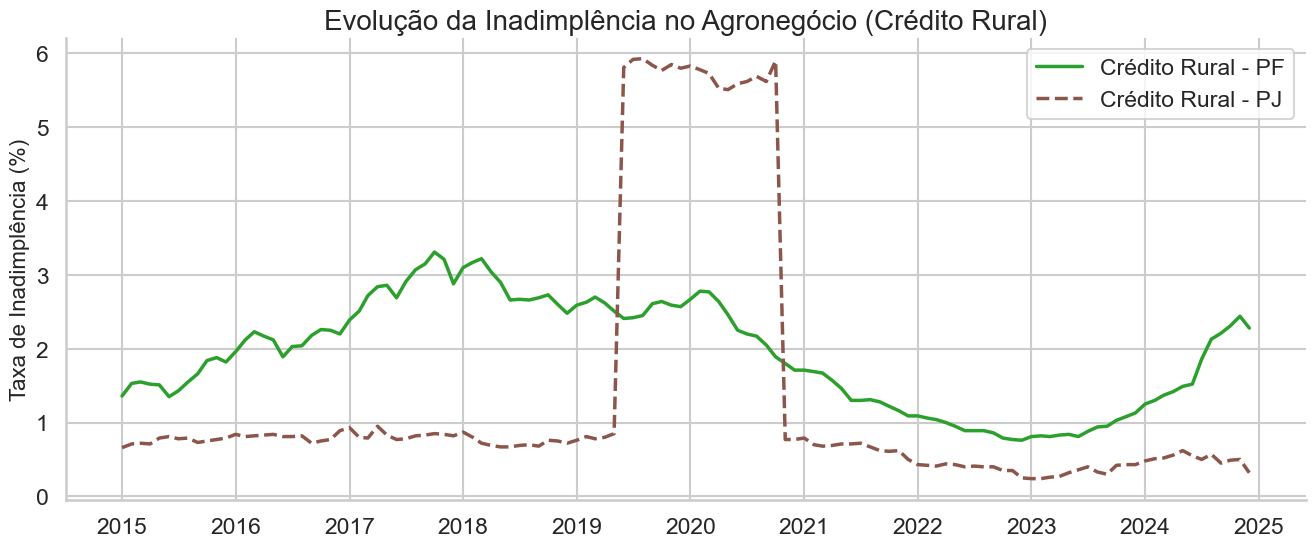

In [6]:
# Plot: Inadimplência Rural
plt.figure(figsize=(16, 6))

sns.lineplot(data=df_mestre, x=df_mestre.index, y="inad_rd_pf_cr_rur_tot", label="Crédito Rural - PF", linewidth=2.5, color="#2ca02c")
sns.lineplot(data=df_mestre, x=df_mestre.index, y="inad_rd_pj_cr_rur_tot", label="Crédito Rural - PJ", linewidth=2.5, linestyle="--", color="#8c564b")

plt.title("Evolução da Inadimplência no Agronegócio (Crédito Rural)")
plt.ylabel("Taxa de Inadimplência (%)")
plt.xlabel("")
plt.legend()
sns.despine()

plt.show()

## 4. Análise de Correlações (*Heatmaps*)
Investigamos a relação linear entre as variáveis macroeconômicas e os nossos *targets* (alvos).
* **Interpretação:** Cores quentes (vermelho) indicam correlação positiva (sobe junto); cores frias (azul) indicam correlação negativa (inversa).

Shape antes da correção: (252, 32)
Shape após correção: (132, 31)


,inad_pj_tot,inad_pf_tot,inad_rd_pf_cr_rur_tot,inad_rd_pj_cr_rur_tot,ipca,spread_pf,spread_pj,spread_tot,icms_petroleo,soja_triturada_expt,...,p14m_desocupadas_mil,p14m_fora_forca_trabalho_mil,tx_foca_trabalho_p14m_pct,tx_desocupacao_p14m_pct,insolacao_total_h,precipitacao_total_mm,temp_max_media_c,umidade_media_pct,flag_pandemia,flag_greve_caminhoneiros
data,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1.98,3.75,1.36,0.66,2.50,22.39,8.70,15.68,5556575.0,3.510272e+07,...,7965.0,59812.0,62.4,8.0,230.26,118.75,32.58,70.55,0.0,0.0
2015-02-01,1.99,3.81,1.53,0.71,2.37,23.23,9.05,16.28,5494786.0,3.461604e+08,...,7965.0,59812.0,62.4,8.0,171.73,169.88,31.28,76.14,0.0,0.0
2015-03-01,2.06,3.67,1.55,0.72,3.36,22.91,8.85,16.03,5076328.0,2.211790e+09,...,7965.0,59812.0,62.4,8.0,180.71,188.78,30.71,78.16,0.0,0.0
2015-04-01,2.24,3.75,1.52,0.71,0.78,23.85,9.27,16.75,5880802.0,2.534258e+09,...,8408.0,59567.0,62.7,8.4,195.01,128.62,30.29,77.95,0.0,0.0
2015-05-01,2.27,3.86,1.51,0.79,1.22,24.42,9.26,17.05,5512832.0,3.612717e+09,...,8408.0,59567.0,62.7,8.4,193.34,105.86,28.82,78.24,0.0,0.0


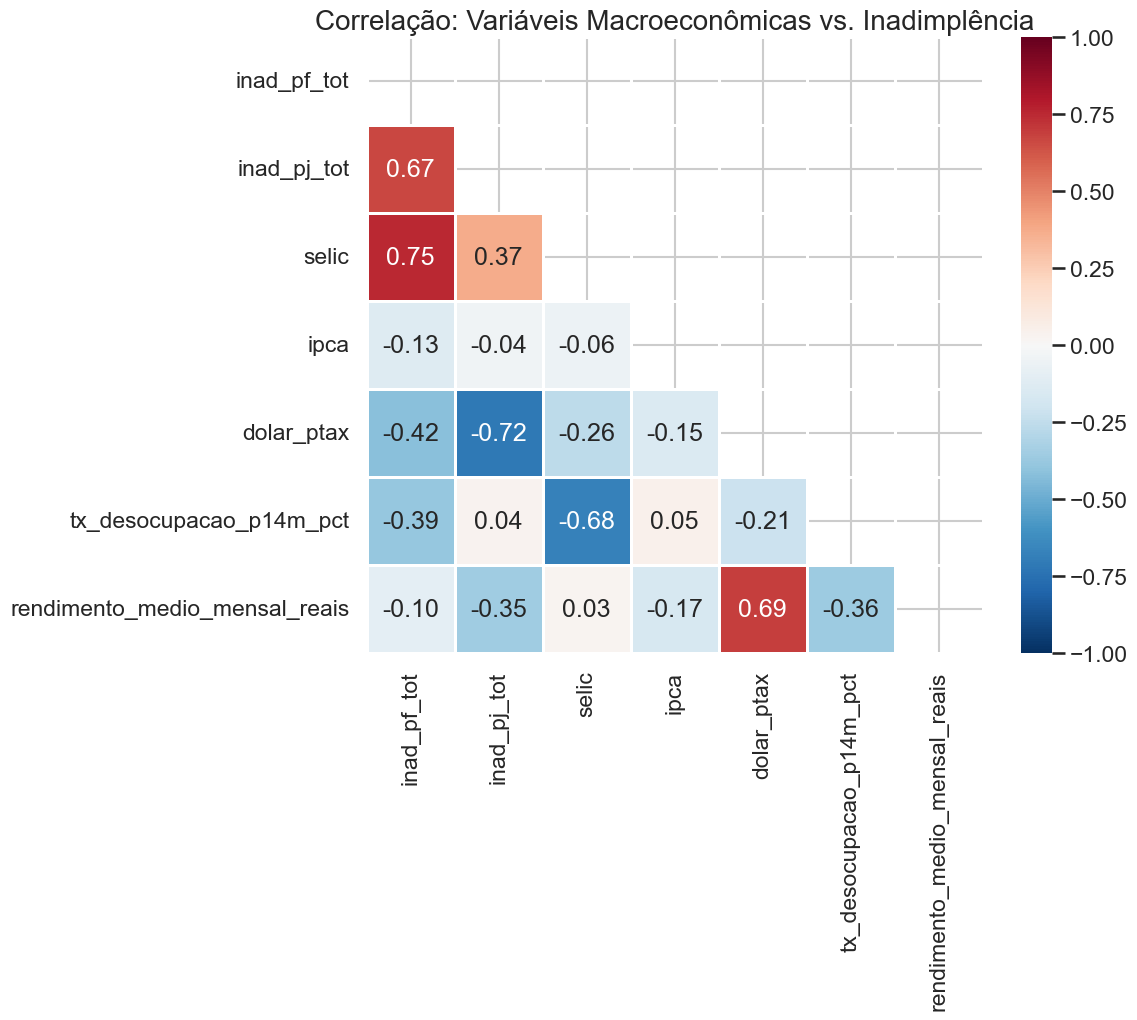

In [13]:
# --- CORREÇÃO DO DESALINHAMENTO ---
print(f"Shape antes da correção: {df_mestre.shape}")

# 1. Resampling para 'Month Start' (MS)
# ADICIONADO: numeric_only=True para ignorar colunas de texto
df_mestre = df_mestre.resample("MS").mean(numeric_only=True)

print(f"Shape após correção: {df_mestre.shape}")

# Check visual: Agora as datas devem ser todas dia 01 (2015-01-01, 2015-02-01...)
display(df_mestre.head())

# --- PLOTANDO O HEATMAP ---
# Seleção de variáveis Macro
cols_macro = [
    "inad_pf_tot", "inad_pj_tot",   # Alvos
    "selic", "ipca", "dolar_ptax",  # Macro
    "tx_desocupacao_p14m_pct",      # Trabalho
    "rendimento_medio_mensal_reais" # Renda
]

# Matriz de correlação
corr_macro = df_mestre[cols_macro].corr()

# Plot
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_macro, dtype=bool))

sns.heatmap(corr_macro, mask=mask, annot=True, cmap="RdBu_r", center=0, 
            vmin=-1, vmax=1, fmt=".2f", linewidths=1, square=True)

plt.title("Correlação: Variáveis Macroeconômicas vs. Inadimplência")
plt.show()

### 4.1. Correlações Climáticas e Agro
Existe relação entre fatores climáticos (chuva, temperatura) e a inadimplência no campo?

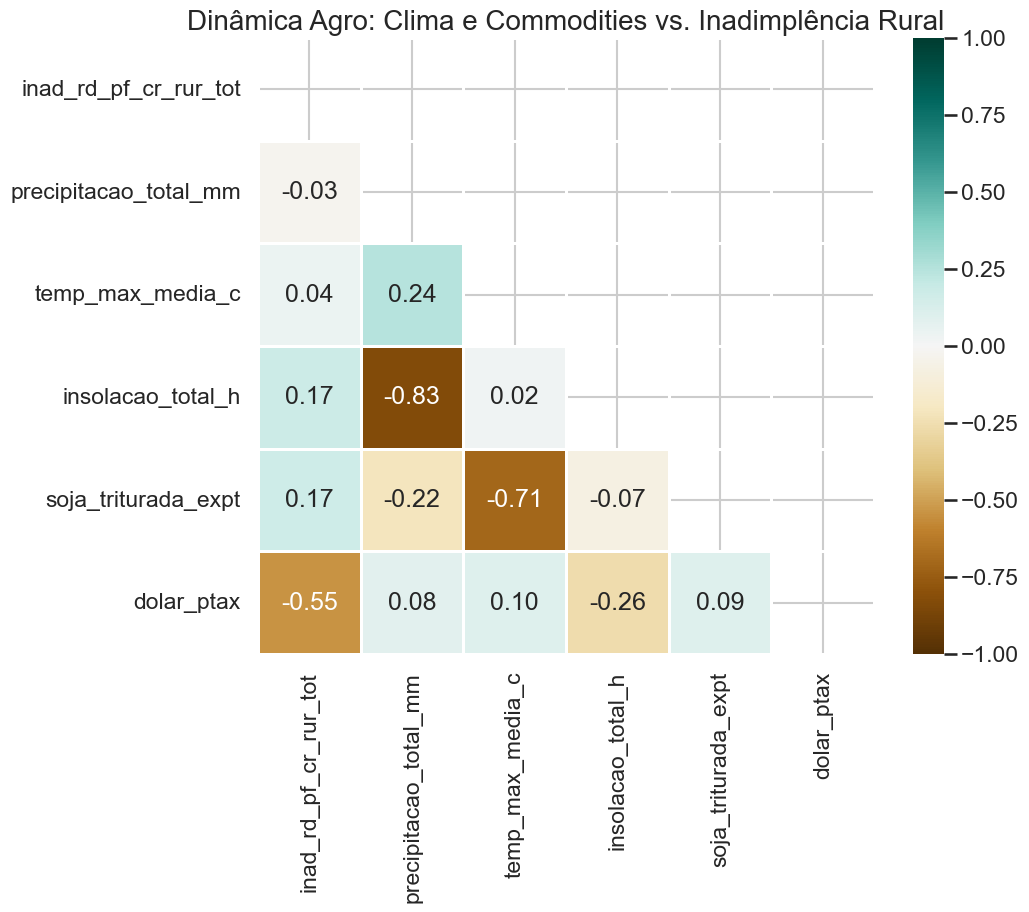

In [14]:
cols_agro = [
    "inad_rd_pf_cr_rur_tot", 
    "precipitacao_total_mm", 
    "temp_max_media_c", 
    "insolacao_total_h",
    "soja_triturada_expt", # Preço/Volume commodities
    "dolar_ptax"
]

corr_agro = df_mestre[cols_agro].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_agro, dtype=bool))

sns.heatmap(corr_agro, mask=mask, annot=True, cmap="BrBG", center=0, 
            vmin=-1, vmax=1, fmt=".2f", linewidths=1, square=True)

plt.title("Dinâmica Agro: Clima e Commodities vs. Inadimplência Rural")
plt.show()

## 5. Distribuição por Períodos Presidenciais
Analisamos como a distribuição da inadimplência se comportou em diferentes governos.
> **Nota:** A análise não implica causalidade direta, apenas descreve o comportamento da variável durante os mandatos.

C:\Users\pedro\AppData\Local\Temp\ipykernel_15028\2012573465.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analise, x="presidente", y="inad_pf_tot", order=ordem_pres, palette="Set2")


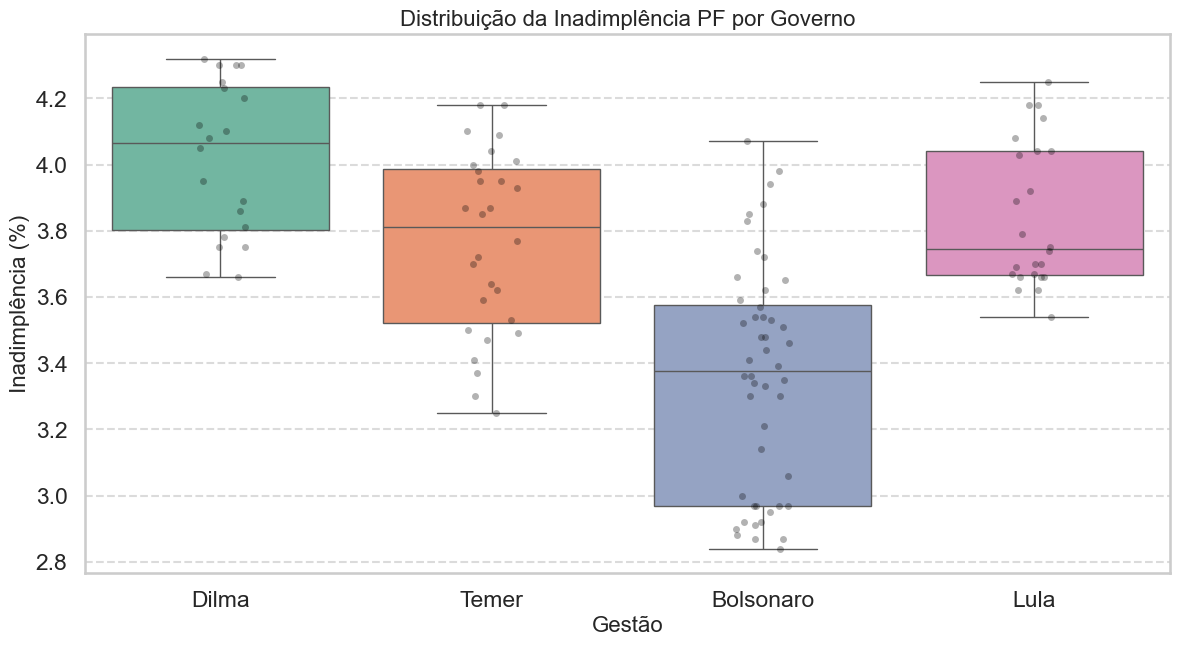

In [16]:
# --- ANÁLISE POLÍTICA (Recuperando a coluna Presidente) ---

# 1. Preparar o DataFrame para o gráfico
df_analise = df_mestre.reset_index()

# 2. Como o .mean() apagou a coluna de texto, vamos recuperá-la do arquivo original
path_eventos = BASE_PATH / "df_eventos_politicos.csv"

if path_eventos.exists():
    # Carrega apenas Data e Presidente
    df_pol = pd.read_csv(path_eventos)
    
    # Converte data para garantir o casamento perfeito (dia 1 do mês)
    if "data" in df_pol.columns:
        df_pol["data"] = pd.to_datetime(df_pol["data"])
        # Garante que a data seja o primeiro dia do mês (ex: 2015-01-15 vira 2015-01-01)
        # Isso é vital para o merge funcionar com o df_mestre resamplado
        df_pol["data"] = df_pol["data"].dt.to_period('M').dt.to_timestamp()

    # Faz o merge (Junta a inadimplência com o nome do presidente)
    df_analise = pd.merge(df_analise, df_pol[["data", "presidente"]], on="data", how="left")
    
    # Remover linhas onde 'presidente' ficou vazio (se houver datas sem governo mapeado)
    df_analise = df_analise.dropna(subset=['presidente'])

    # --- PLOT ---
    plt.figure(figsize=(14, 7))

    # Definindo ordem cronológica para o gráfico
    ordem_pres = ["Dilma", "Temer", "Bolsonaro", "Lula"]
    
    # Filtra apenas presidentes que estão na lista (para evitar erros se houver outros nomes)
    df_analise = df_analise[df_analise["presidente"].isin(ordem_pres)]

    sns.boxplot(data=df_analise, x="presidente", y="inad_pf_tot", order=ordem_pres, palette="Set2")
    
    # Adiciona os pontos reais (jitter) para ver a densidade
    sns.stripplot(data=df_analise, x="presidente", y="inad_pf_tot", order=ordem_pres, 
                  color="black", alpha=0.3, jitter=True)

    plt.title("Distribuição da Inadimplência PF por Governo", fontsize=16)
    plt.ylabel("Inadimplência (%)")
    plt.xlabel("Gestão")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

else:
    print("Arquivo de eventos políticos não encontrado.")

## 6. Conclusões e Próximos Passos

Desta análise exploratória, observamos:
1.  **Tendência de Queda:** Houve uma tendência estrutural de queda na inadimplência PF de 2016 até o início de 2021.
2.  **Impacto do Ciclo de Crédito:** A inadimplência apresenta forte correlação positiva com a taxa de Desocupação e forte correlação negativa com a Renda (o que faz sentido econômico).
3.  **Divergência Agro:** O crédito rural possui dinâmica distinta, com correlações climáticas mais fracas no agregado nacional (possivelmente devido à média nacional suavizar os extremos regionais).

**Próximo Passo:**
Utilizar estas variáveis para treinar modelos preditivos (Machine Learning) para prever a tendência da inadimplência nos próximos meses.